# Naive Bayes

## Packages

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
import os
import re

## Data Preprocessing

In [7]:
path = os.getcwd()
print(path)

/home/pavan/Desktop/Projects/ML-assignment/Naive-Bayes


In [8]:
file1 = open('dataset_NB.txt', 'r')
Lines = file1.readlines()

<b>Insert data from txt file to a dictionary.
Sepearte out the Labels.</b>

In [9]:
dict_data = {'text':[], 'label':[]}
for i in Lines:
  label = i[-2]
  string = i[:-2]
  dict_data['text'].append(string)
  dict_data['label'].append(label)
dict_data['label'][-1] = '0'

In [10]:
dict_data['text'][:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.  ',
 'Good case, Excellent value. ',
 'Great for the jawbone.  ',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!! ',
 'The mic is great.   ',
 'I have to jiggle the plug to get it to line up right to get decent volume.  ',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one. ',
 'If you are Razr owner...you must have this! ',
 'Needless to say, I wasted my money. ',
 'What a waste of money and time!.    ']

In [11]:
dict_data['label'][:10]

['0', '1', '1', '0', '1', '0', '0', '1', '0', '0']

<b>Create a Dataframe with the data from "dict_data".
Then, visualize the data.</b>

In [12]:
df = pd.DataFrame(dict_data)

In [36]:
df

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [13]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [14]:
n = df['label'].value_counts()
n = n.to_numpy()

<b>As shown below, there are 500 lines with postive and 500 lines with negitive sentiment.
This is an eqaully distributed dataset.</b>

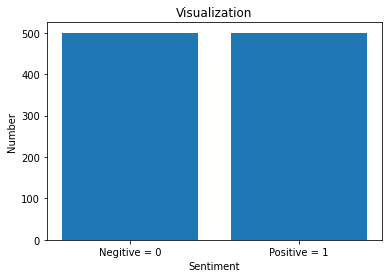

In [15]:
plt.bar(['Negitive = 0','Positive = 1'], n)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

<b>Function Defined for processing the text data. This includes:
    <ol>
        <li>Removing stop words</li>
        <li>Removing commas, fullstops, hyphens</li>
        <li>Numerical Data</li>
    </ol>
</b>

In [16]:
def data_preprocess(textdata):
    Processed =[]

    alphaPattern = r"[^\w\s]"
    numPattern = r"[\d]"
    sequenceFind = r"(.)\1\1+"
    sequenceReplace = r"\1\1"

    for line in textdata:
        line = line.lower()
        line = re.sub(alphaPattern, ' ', line)
        line = re.sub(numPattern, ' ', line)
        line = re.sub(sequenceFind, sequenceReplace, line)

        lineWords = ''
        for text in line.split():
            if len(text)>2:
                lineWords += (text +' ')

        Processed.append(lineWords)

    return Processed

In [17]:
dict_data['text'] = data_preprocess(dict_data['text'])

In [18]:
dict_data['text'][0:10]

['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ',
 'tied charger for conversations lasting more than minutes major problems ',
 'the mic great ',
 'have jiggle the plug get line right get decent volume ',
 'you have several dozen several hundred contacts then imagine the fun sending each them one one ',
 'you are razr owner you must have this ',
 'needless say wasted money ',
 'what waste money and time ']

## Vectorizer

<b>Created a list of stop words, which do not contribute to the sentiment of a text.</b>

In [19]:
stop_words = ['hasn', 'few', "you're", 'which', 'having', 'aren', 'did', 'through', 'only', "couldn't", 'if', 'until', 'when', 'below', 'll', 'yourselves', 'their', 't', 'do', 're', 'couldn', 'doing', 'weren', 'he', 'they', 'just', 'isn', 'mustn', 'itself', 'but', 'haven', 'with', "you'd", 'where', "that'll", 'd', 'wouldn', 'once', 'am', 'is', 'on', 'she', 'such', 'won', 'was', 'being', 'ain', 'too', "you'll", 'each', 'are', 'ma', 'again', "it's", 'what', 'has', 'wasn', 'does', 'ours', 'now', 'them', "wasn't", 'you', 'above', 'from', 'can', 'will', 'theirs', 'because', 'mightn', 'i', 'off', 'shouldn', "weren't", 'doesn', 'him', "wouldn't", "mustn't", 'here', 'be', 'been', 'not', 'as', 'her', 'so', 'after', 'why', "isn't", 'his', 's', 'who', 'up', 'whom', "shouldn't", "you've", 'further', 'both', 'have', 've', 'then', 'all', "don't", 'that', 'm', 'very', "doesn't", 'and', 'while', "haven't", 'some', 'themselves', 'herself', "needn't", 'this', 'how', 'against', 'own', 'o', 'down', 'those', 'had', 'other', "didn't", 'were', 'to', 'there', 'yourself', "hadn't", 'for', 'of', 'at', 'no', 'most', 'in', 'or', 'more', 'your', 'should', "won't", 'any', 'it', "hasn't", 'by', 'the', 'himself', 'than', 'ourselves', 'under', "shan't", 'these', 'me', "mightn't", 'a', 'about', 'nor', 'before', 'hadn', 'didn', 'out', 'our', 'don', 'needn', 'same', 'hers', 'y', 'my', 'we', 'during', 'shan', 'over', 'an', "should've", 'its', "aren't", 'between', 'into', 'myself', 'yours', "she's"]

In [20]:
label = dict_data['label']
for i in range(0, len(label)): 
    label[i] = int(label[i]) 
dict_data['label'] = label

In [21]:
def vectorizer(data, label):
    '''
    Takes a list of sentences as input.
    Returns a dictionary containing unique words as keys and their respective count as values.
    '''
    dict_words = {}
    
    for line, label in zip(data, label):
        for text in line.split():
            if text not in stop_words:
                pair = (text, label)
                if pair in dict_words.keys():
                    dict_words[pair] += 1
                else:
                    dict_words[pair] = 1
    
    return dict_words        

In [22]:
dict_words = vectorizer(dict_data['text'], dict_data['label'])

## Train Test Split

<b> Split the data given into train data and test data. Here train is of size (0.7*(size of dataset)) and test size is (0.3*(size of dataset)).</b>

In [23]:
train_size = int(0.7*(len(dict_data['text'])))
X_train = dict_data['text'][:train_size]
Y_train = dict_data['label'][:train_size]
X_test = dict_data['text'][train_size:]
Y_test = dict_data['label'][train_size:]

In [294]:
df = pd.DataFrame({'sentiments': Y_train})

n = df['sentiments'].value_counts()
print(n)
n = n.to_numpy()

1    356
0    344
Name: sentiments, dtype: int64


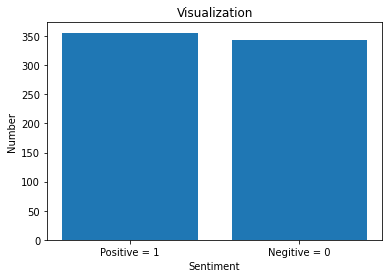

In [288]:
plt.bar(['Positive = 1','Negitive = 0'], n)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

## Naive Bayes Model

In [334]:
class NaiveBayesAlgo:

    def __init__(self, alpha=1):
        self.vocab={}
        self.prob_pos_words = {}
        self.prob_neg_words = {}  
        self.pos_count = 0
        self.neg_count = 0
        self.pos_prior = 0
        self.neg_prior = 0
        self.alpha = alpha

        

    def fit(self, X, Y, vectorized, initialize=False):
        '''
        Function to train our model.
        X = List of input sentences
        Y = List of labels for input sentences
        vectorized = Dictionary of counts of each unique word with their respective labels
        '''

        if initialize:
            self.vocab = {}
            self.prob_pos_words = {}
            self.prob_neg_words = {}
            self.pos_count = 0
            self.neg_count = 0
            self.pos_prior = 0
            self.neg_prior = 0
        
        self.vocab = vectorized

        self.pos_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[1]
        self.neg_count = pd.DataFrame({'sentiments': Y})['sentiments'].value_counts()[0]
                        
        voc_len = len(list(self.vocab.keys()))
        for key in list(self.vocab.keys()):
            if key[1]==1:
                self.prob_pos_words[key[0]] = (self.vocab[key] + self.alpha) / (self.pos_count + (self.alpha * voc_len))

            elif key[1]==0:
                self.prob_neg_words[key[0]] = (self.vocab[key] + self.alpha) / (self.neg_count + (self.alpha * voc_len))

        
        self.pos_prior = self.pos_count/(self.pos_count + self.neg_count)
        self.neg_prior = self.neg_count/(self.pos_count + self.neg_count)
        
        
    def predict(self, X):
        '''
        Input a list containing preprocessed tweets.
        '''
        
        pos_prob = self.pos_prior
        neg_prob = self.neg_prior
        y_true=[]
        for i in range(len(X)):
            for word in X[i].split():
                if word in list(self.prob_pos_words.keys()):
                    if self.prob_pos_words[word]>0:
                        pos_prob *= self.prob_pos_words[word]

                if word in list(self.prob_neg_words.keys()):
                    if self.prob_neg_words[word]>0:
                        neg_prob *= self.prob_neg_words[word]


            if pos_prob <= neg_prob:
                y_true.append(1)
            else:
                y_true.append(0)
            pos_prob = self.pos_prior
            neg_prob = self.neg_prior
            

        return y_true
    
    def partition(self, data, fold, k):
        '''
        Partitions the given data into train and test data, such that the k-1 folds are taken as train and kth fold is taken as test.
        
        data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
        fold: index of fold to be taken as test.
        k: No. of folds
        '''
        
        size = len(dict_data['text'])
        start = int((size/k)*fold)
        end = int((size/k)*(fold+1))
        
        X_test = data['text'][start:end]
        Y_test = data['label'][start:end]
        
        vector = np.array(data['text'])
        X_train = np.concatenate((vector[:start], vector[end:]))
        vector = np.array(data['label'])
        Y_train = np.concatenate((vector[:start], vector[end:]))
        
        return X_train, X_test, Y_train, Y_test
    
    def cross_val(self, data, k):
        '''
        k-fold validation on the given data.
        data: Dictionary of values containing text and their sentiment labels, ie, 0 and 1.
        k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0
        
        for i in range(k):
            
            X_train, X_test, Y_train, Y_test = self.partition(data, i, k)            
            
            self.fit(X_train, Y_train, dict_words, initialize=True)
            
            y_pred = self.predict(X_test)
            dict = self.report(Y_test, y_pred)
            
            TP+=dict['TP']
            TN+=dict['TN']
            FP+=dict['FP']
            FN+=dict['FN']
            Total+=dict['Total']
            accuracy+=dict['Accuracy']
            precision+=dict['Precision']
            recall+=dict['Recall']
            
            self.evaluate(X_test, Y_test)
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print('Final Classification Report') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(avg)
        
    
    def evaluate(self, x_test, y_test):
        '''
        Funciton to evaluate our model.
        '''

        y_pred = self.predict(x_test)
        dict = self.report(y_test, y_pred)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        self.confusion_matrix(dict)
        
    
    def report(self, y_pred, y_test):
        '''
        Input: list of predicted and true labels.
        Ouput: Dictionary of TP, TN, FP, FN, Total, Accuracy, Recall, Precision
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()
        

## Training

In [335]:
NB = NaiveBayesAlgo()

<b> Training and evaluating the model with train and test data, which have sizes in the ratio 7:3. This is 2-fold cross validation.
Done to test the model.</b>

In [336]:
%%time
NB.fit(X_train, Y_train, dict_words, initialize=True)

CPU times: user 6.39 ms, sys: 670 µs, total: 7.06 ms
Wall time: 7.85 ms


In [337]:
print(NB.pos_prior, NB.neg_prior, NB.pos_count, NB.neg_count)

0.5085714285714286 0.49142857142857144 356 344


## Evaluation

<b> Evaluating for test data. </b>

Classification Report
                             
TP                         97
TN                        143
FP                         47
FN                         13
Total                     300
Accuracy                  0.8
Recall     0.8818181818181818
Precision  0.6736111111111112


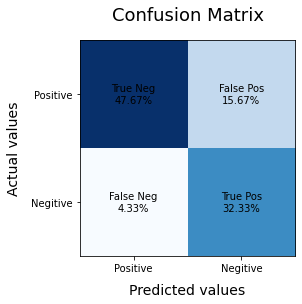

In [338]:
NB.evaluate(X_test, Y_test)

## Cross Validation

Classification Report
                             
TP                         56
TN                         59
FP                         21
FN                          6
Total                     142
Accuracy   0.8098591549295775
Recall     0.9032258064516129
Precision  0.7272727272727273


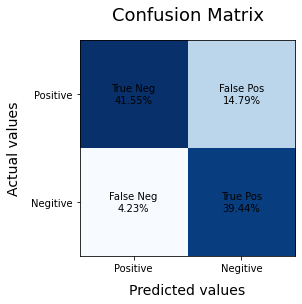

Classification Report
                             
TP                         57
TN                         64
FP                         16
FN                          6
Total                     143
Accuracy   0.8461538461538461
Recall     0.9047619047619048
Precision  0.7808219178082192


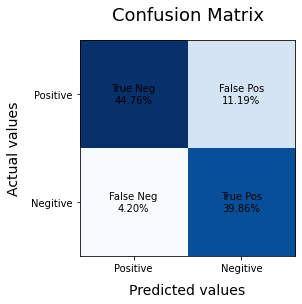

Classification Report
                             
TP                         46
TN                         63
FP                         29
FN                          5
Total                     143
Accuracy   0.7622377622377622
Recall     0.9019607843137255
Precision  0.6133333333333333


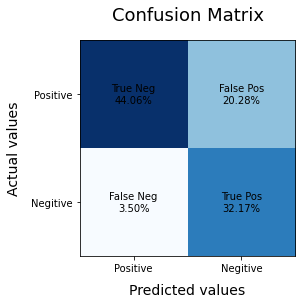

Classification Report
                             
TP                         54
TN                         65
FP                         18
FN                          6
Total                     143
Accuracy   0.8321678321678322
Recall                    0.9
Precision                0.75


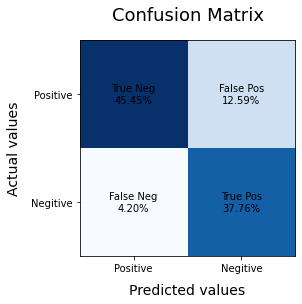

Classification Report
                             
TP                         46
TN                         71
FP                         20
FN                          6
Total                     143
Accuracy   0.8181818181818182
Recall     0.8846153846153846
Precision   0.696969696969697


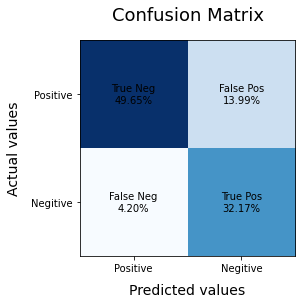

Classification Report
                             
TP                         47
TN                         68
FP                         23
FN                          5
Total                     143
Accuracy   0.8041958041958042
Recall     0.9038461538461539
Precision  0.6714285714285714


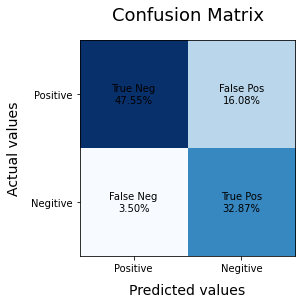

Classification Report
                             
TP                         45
TN                         69
FP                         22
FN                          7
Total                     143
Accuracy   0.7972027972027972
Recall     0.8653846153846154
Precision  0.6716417910447762


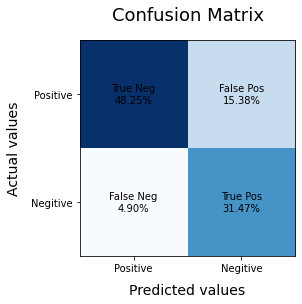

Final Classification Report
                             
TP         50.142857142857146
TN          65.57142857142857
FP         21.285714285714285
FN          5.857142857142857
Total      142.85714285714286
Accuracy    0.809999859295634
Recall     0.8948278070533424
Precision  0.7016382911224751


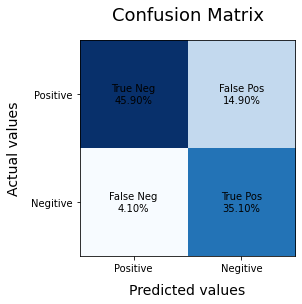

In [339]:
NB.cross_val(dict_data, 7)

## Predict

In [34]:
test = ['there way for plug here the unless converter ',
 'good case excellent value ',
 'great for the jawbone ']
NB.predict(test)

[0, 1, 1]

## Limitations of Naive Bayes Classifier